This code sets up the required packages and imports necessary libraries to build a deep neural network model for customer churn prediction. The code installs the specific version of Keras (2.3.1) and Talos, followed by importing libraries for data manipulation, visualization, preprocessing, and neural network construction. TensorFlow and Keras are used to create and optimize the deep neural network, while TensorBoard's HParams API is utilized for hyperparameter tracking.

In [1]:
!pip install q keras==2.3.1 -q
!pip install talos -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.3.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 34.0 MB/s eta 0:00:00
     ━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, Adamax

This code imports the Talos library for hyperparameter optimization and defines a utility function for learning rate normalization. Additionally, it integrates Google Drive with Google Colab to enable access and storage of data and results directly from the user's Google Drive account.

In [3]:
#import talos library (after install keras and talos)
import talos as ta
from talos.utils import lr_normalizer
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code snippet reads the "Bank Customer Churn Prediction.csv" dataset, displays the first five rows, and drops the 'customer_id' column. It then separates continuous and categorical variables and reorders the DataFrame columns for further analysis.

In [4]:
# Read the dataset and drop the 'customer_id' column
df = pd.read_csv('/content/drive/MyDrive/Bank Customer Churn Prediction.csv').drop('customer_id', axis=1)

# Define continuous and categorical variables
continuous_vars = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical_vars = ['country', 'gender', 'credit_card', 'active_member']

In [5]:
# Reorder the DataFrame columns
df = df[['churn'] + continuous_vars + categorical_vars]

# Display the first five rows of the processed DataFrame
df.head()

,churn,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
0,1,619,42,2,0.00,1,101348.88,France,Female,1,1
1,0,608,41,1,83807.86,1,112542.58,Spain,Female,0,1
2,1,502,42,8,159660.80,3,113931.57,France,Female,1,0
3,0,699,39,1,0.00,2,93826.63,France,Female,0,0
4,0,850,43,2,125510.82,1,79084.10,Spain,Female,1,1


This code snippet updates the 'credit_card' and 'active_member' columns to have -1 instead of 0, ensuring a negative influence on the model. It then applies one-hot encoding to the 'country' and 'gender' categorical variables and displays the updated DataFrame.

In [6]:
# Update 'credit_card' and 'active_member' columns to have a negative influence
df['credit_card'].replace(0, -1, inplace=True)
df['active_member'].replace(0, -1, inplace=True)

# Apply one-hot encoding to 'country' and 'gender' categorical variables
df = pd.get_dummies(df, columns=['country', 'gender'])

# Display the first five rows of the updated DataFrame
df.head()

,churn,credit_score,age,tenure,balance,products_number,estimated_salary,credit_card,active_member,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,1,619,42,2,0.00,1,101348.88,1,1,1,0,0,1,0
1,0,608,41,1,83807.86,1,112542.58,-1,1,0,0,1,1,0
2,1,502,42,8,159660.80,3,113931.57,1,-1,1,0,0,1,0
3,0,699,39,1,0.00,2,93826.63,-1,-1,1,0,0,1,0
4,0,850,43,2,125510.82,1,79084.10,1,1,0,0,1,1,0


This code snippet scales the continuous variables, converts the DataFrame to NumPy arrays, splits the dataset into training and testing sets, and then converts the NumPy arrays to TensorFlow tensors for further processing.

In [7]:
# Scale the continuous variables
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

In [8]:
# Convert DataFrame to NumPy arrays
X = df.drop(labels='churn', axis='columns').to_numpy()
Y = df['churn'].to_numpy()

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=30, test_size=0.2)

In [10]:
# Convert NumPy arrays to TensorFlow tensors
X_train_tf = tf.stack(X_train)
Y_train_tf = tf.stack(Y_train)
X_test_tf = tf.stack(X_test)
Y_test_tf = tf.stack(Y_test)

***Hyperparamter tuning using random search with the random method "quantum"***


This code snippet defines a customizable deep learning model with a pre-defined parameter space, creates a sequential neural network with input, hidden, and output layers, and fits the model to the provided training data.

In [11]:
# Set the parameter space
p = {'lr': [0.01, 0.1],
     'first_neuron': [32, 64],
     'hidden_layers': [2, 3, 4, 5],
     'batch_size': [32, 64],
     'epochs': [100],
     'dropout': [0, 0.5],
     'weight_regulizer': ['GlorotNormal', 'HeNormal'],
     'shape': ['brick', 'long_funnel'],
     'optimizer': ['Adam', 'Nadam', 'Adamax'],
     'losses': ['binary_crossentropy'],
     'activation': ['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [12]:
# Determine the number of input features
n_features = X_train.shape[1]

In [13]:
# Define the model
def achraf_model(X_train, Y_train, X_test, Y_test, params):
    model = Sequential()
    
    # Add input layer
    model.add(Dense(params['first_neuron'], kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(0.09), input_shape=(n_features,), activation=params['activation']))
    model.add(BatchNormalization())
    
    # Add hidden layers
    hidden_layers = [
        {'units': 77, 'l2': 0.08},
        {'units': 70, 'l2': 0.07},
        {'units': 70, 'l2': 0.06},
        {'units': 63, 'l2': 0.0}
    ]

    for layer in hidden_layers:
        model.add(Dense(layer['units'], kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(layer['l2']), activation=params['activation']))
        model.add(BatchNormalization())

    # Add output layer
    model.add(Dense(1, activation=params['last_activation'], name="predictions"))

    # Compile the model
    model.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    # Fit the model
    history = model.fit(X_train, Y_train, epochs=51, validation_split=0.25, batch_size=32, verbose=2, validation_data=(X_test, Y_test))
    
    return history, model

This code snippet performs hyperparameter tuning using the random search method "quantum" with Talos. It analyzes and prints the results, including highest accuracy, lowest loss, highest validation accuracy, and lowest validation loss. Finally, it generates plots for the given metrics.

In [14]:
# Hyperparameter tuning using random search with the random method "quantum"
scan_object = ta.Scan(x=X_train,
                      y=Y_train,
                      x_val=X_test,
                      y_val=Y_test,
                      params=p,
                      model=achraf_model,
                      experiment_name='churn',
                      random_method='quantum',
                      fraction_limit=0.01)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/51
250/250 - 4s - loss: 18.8005 - accuracy: 0.7721 - val_loss: 7.7690 - val_accuracy: 0.7820 - 4s/epoch - 16ms/step
Epoch 2/51
250/250 - 1s - loss: 4.1650 - accuracy: 0.8336 - val_loss: 2.1941 - val_accuracy: 0.7855 - 774ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 1.3200 - accuracy: 0.8365 - val_loss: 0.9266 - val_accuracy: 0.7845 - 784ms/epoch - 3ms/step
Epoch 4/51
250/250 - 1s - loss: 0.6596 - accuracy: 0.8374 - val_loss: 0.5725 - val_accuracy: 0.8120 - 789ms/epoch - 3ms/step
Epoch 5/51
250/250 - 1s - loss: 0.5000 - accuracy: 0.8315 - val_loss: 0.4898 - val_accuracy: 0.7985 - 731ms/epoch - 3ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4492 - accuracy: 0.8366 - val_loss: 0.4863 - val_accuracy: 0.8080 - 783ms/epoch - 3ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4465 - accuracy: 0.8360 - val_loss: 0.4137 - val_accuracy: 0.8550 - 735ms/epoch - 3ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4289 - accuracy: 0.8421 - val_loss: 0.4209 - val_accuracy: 0.8460 - 1s/epoch - 5ms/step
Epoc

  7%|▋         | 1/15 [01:25<19:55, 85.42s/it]

Epoch 1/51
250/250 - 4s - loss: 10.5436 - accuracy: 0.7272 - val_loss: 7.3524 - val_accuracy: 0.7855 - 4s/epoch - 15ms/step
Epoch 2/51
250/250 - 1s - loss: 5.5466 - accuracy: 0.8270 - val_loss: 4.2010 - val_accuracy: 0.8095 - 1s/epoch - 4ms/step
Epoch 3/51
250/250 - 1s - loss: 3.3495 - accuracy: 0.8388 - val_loss: 2.6906 - val_accuracy: 0.8360 - 1s/epoch - 4ms/step
Epoch 4/51
250/250 - 1s - loss: 2.2404 - accuracy: 0.8471 - val_loss: 1.8912 - val_accuracy: 0.8420 - 1s/epoch - 5ms/step
Epoch 5/51
250/250 - 2s - loss: 1.6281 - accuracy: 0.8475 - val_loss: 1.4340 - val_accuracy: 0.8350 - 2s/epoch - 6ms/step
Epoch 6/51
250/250 - 1s - loss: 1.2506 - accuracy: 0.8504 - val_loss: 1.1213 - val_accuracy: 0.8465 - 1s/epoch - 5ms/step
Epoch 7/51
250/250 - 1s - loss: 1.0093 - accuracy: 0.8474 - val_loss: 0.9371 - val_accuracy: 0.8380 - 1s/epoch - 5ms/step
Epoch 8/51
250/250 - 1s - loss: 0.8430 - accuracy: 0.8491 - val_loss: 0.7935 - val_accuracy: 0.8455 - 1s/epoch - 5ms/step
Epoch 9/51
250/250 - 1

 13%|█▎        | 2/15 [02:16<14:08, 65.26s/it]

Epoch 1/51
250/250 - 7s - loss: 20.0802 - accuracy: 0.7820 - val_loss: 7.5814 - val_accuracy: 0.7820 - 7s/epoch - 30ms/step
Epoch 2/51
250/250 - 1s - loss: 4.0179 - accuracy: 0.8365 - val_loss: 2.0711 - val_accuracy: 0.7830 - 967ms/epoch - 4ms/step
Epoch 3/51
250/250 - 1s - loss: 1.3113 - accuracy: 0.8315 - val_loss: 0.8998 - val_accuracy: 0.8035 - 972ms/epoch - 4ms/step
Epoch 4/51
250/250 - 1s - loss: 0.6763 - accuracy: 0.8275 - val_loss: 0.5508 - val_accuracy: 0.8200 - 1s/epoch - 4ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4934 - accuracy: 0.8280 - val_loss: 0.5206 - val_accuracy: 0.8000 - 977ms/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4454 - accuracy: 0.8204 - val_loss: 0.4735 - val_accuracy: 0.8100 - 999ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4306 - accuracy: 0.8246 - val_loss: 0.5127 - val_accuracy: 0.7940 - 914ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4281 - accuracy: 0.8232 - val_loss: 0.4668 - val_accuracy: 0.8055 - 954ms/epoch - 4ms/step
Epoc

 20%|██        | 3/15 [03:44<15:08, 75.70s/it]

Epoch 1/51
250/250 - 4s - loss: 23.9590 - accuracy: 0.7303 - val_loss: 15.1383 - val_accuracy: 0.8000 - 4s/epoch - 15ms/step
Epoch 2/51
250/250 - 1s - loss: 10.5952 - accuracy: 0.8256 - val_loss: 7.3291 - val_accuracy: 0.7950 - 1s/epoch - 4ms/step
Epoch 3/51
250/250 - 1s - loss: 5.4759 - accuracy: 0.8338 - val_loss: 4.1333 - val_accuracy: 0.8040 - 1s/epoch - 5ms/step
Epoch 4/51
250/250 - 1s - loss: 3.2666 - accuracy: 0.8447 - val_loss: 2.6257 - val_accuracy: 0.8280 - 1s/epoch - 5ms/step
Epoch 5/51
250/250 - 1s - loss: 2.1733 - accuracy: 0.8478 - val_loss: 1.8350 - val_accuracy: 0.8385 - 866ms/epoch - 3ms/step
Epoch 6/51
250/250 - 1s - loss: 1.5655 - accuracy: 0.8421 - val_loss: 1.3498 - val_accuracy: 0.8505 - 761ms/epoch - 3ms/step
Epoch 7/51
250/250 - 1s - loss: 1.1819 - accuracy: 0.8521 - val_loss: 1.0728 - val_accuracy: 0.8430 - 752ms/epoch - 3ms/step
Epoch 8/51
250/250 - 1s - loss: 0.9505 - accuracy: 0.8506 - val_loss: 0.8755 - val_accuracy: 0.8435 - 798ms/epoch - 3ms/step
Epoch 9/

 27%|██▋       | 4/15 [04:33<11:56, 65.14s/it]

Epoch 1/51
250/250 - 6s - loss: 18.7603 - accuracy: 0.7481 - val_loss: 7.6918 - val_accuracy: 0.7825 - 6s/epoch - 26ms/step
Epoch 2/51
250/250 - 1s - loss: 4.1328 - accuracy: 0.8299 - val_loss: 2.1432 - val_accuracy: 0.7845 - 980ms/epoch - 4ms/step
Epoch 3/51
250/250 - 1s - loss: 1.3244 - accuracy: 0.8346 - val_loss: 0.8817 - val_accuracy: 0.8030 - 983ms/epoch - 4ms/step
Epoch 4/51
250/250 - 1s - loss: 0.6690 - accuracy: 0.8382 - val_loss: 0.6100 - val_accuracy: 0.7885 - 909ms/epoch - 4ms/step
Epoch 5/51
250/250 - 1s - loss: 0.5022 - accuracy: 0.8375 - val_loss: 0.4633 - val_accuracy: 0.8385 - 1s/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4439 - accuracy: 0.8422 - val_loss: 0.4345 - val_accuracy: 0.8435 - 928ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4350 - accuracy: 0.8361 - val_loss: 0.4184 - val_accuracy: 0.8385 - 1s/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4104 - accuracy: 0.8496 - val_loss: 0.4173 - val_accuracy: 0.8375 - 1s/epoch - 5ms/step
Epoch 9/51

 33%|███▎      | 5/15 [06:01<12:13, 73.39s/it]

Epoch 1/51
250/250 - 5s - loss: 6.2683 - accuracy: 0.7843 - val_loss: 1.5046 - val_accuracy: 0.7820 - 5s/epoch - 18ms/step
Epoch 2/51
250/250 - 1s - loss: 0.7329 - accuracy: 0.8278 - val_loss: 0.6204 - val_accuracy: 0.7820 - 784ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 0.4558 - accuracy: 0.8195 - val_loss: 0.4552 - val_accuracy: 0.8095 - 812ms/epoch - 3ms/step
Epoch 4/51
250/250 - 1s - loss: 0.4314 - accuracy: 0.8292 - val_loss: 0.4681 - val_accuracy: 0.7960 - 845ms/epoch - 3ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4317 - accuracy: 0.8214 - val_loss: 0.4454 - val_accuracy: 0.8295 - 847ms/epoch - 3ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4277 - accuracy: 0.8251 - val_loss: 0.4423 - val_accuracy: 0.8055 - 890ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4292 - accuracy: 0.8271 - val_loss: 0.4710 - val_accuracy: 0.8025 - 859ms/epoch - 3ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4351 - accuracy: 0.8249 - val_loss: 0.5125 - val_accuracy: 0.7980 - 806ms/epoch - 3ms/step
Ep

 40%|████      | 6/15 [06:53<09:55, 66.19s/it]

Epoch 1/51
250/250 - 4s - loss: 7.4374 - accuracy: 0.7814 - val_loss: 2.4533 - val_accuracy: 0.7820 - 4s/epoch - 14ms/step
Epoch 2/51
250/250 - 1s - loss: 1.2450 - accuracy: 0.8329 - val_loss: 0.7828 - val_accuracy: 0.7820 - 762ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 0.5595 - accuracy: 0.8371 - val_loss: 0.5685 - val_accuracy: 0.7855 - 734ms/epoch - 3ms/step
Epoch 4/51
250/250 - 1s - loss: 0.4728 - accuracy: 0.8366 - val_loss: 0.4767 - val_accuracy: 0.8090 - 868ms/epoch - 3ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4428 - accuracy: 0.8389 - val_loss: 0.4218 - val_accuracy: 0.8490 - 1s/epoch - 5ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4160 - accuracy: 0.8462 - val_loss: 0.4228 - val_accuracy: 0.8415 - 1s/epoch - 5ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4119 - accuracy: 0.8484 - val_loss: 0.4442 - val_accuracy: 0.8065 - 1s/epoch - 5ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4145 - accuracy: 0.8464 - val_loss: 0.4547 - val_accuracy: 0.8070 - 1s/epoch - 4ms/step
Epoch 9/51
250

 47%|████▋     | 7/15 [08:18<09:39, 72.38s/it]

Epoch 1/51
250/250 - 6s - loss: 20.5544 - accuracy: 0.7774 - val_loss: 7.7644 - val_accuracy: 0.7855 - 6s/epoch - 25ms/step
Epoch 2/51
250/250 - 2s - loss: 4.1390 - accuracy: 0.8326 - val_loss: 2.1380 - val_accuracy: 0.7825 - 2s/epoch - 7ms/step
Epoch 3/51
250/250 - 2s - loss: 1.3389 - accuracy: 0.8305 - val_loss: 0.9037 - val_accuracy: 0.7935 - 2s/epoch - 6ms/step
Epoch 4/51
250/250 - 1s - loss: 0.6792 - accuracy: 0.8244 - val_loss: 0.5549 - val_accuracy: 0.8065 - 1s/epoch - 4ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4894 - accuracy: 0.8267 - val_loss: 0.5164 - val_accuracy: 0.7835 - 1s/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4453 - accuracy: 0.8234 - val_loss: 0.4576 - val_accuracy: 0.7990 - 1s/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4307 - accuracy: 0.8241 - val_loss: 0.4457 - val_accuracy: 0.8130 - 1s/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4314 - accuracy: 0.8261 - val_loss: 0.4528 - val_accuracy: 0.7925 - 946ms/epoch - 4ms/step
Epoch 9/51
250/250 

 53%|█████▎    | 8/15 [09:45<08:59, 77.03s/it]

Epoch 1/51
250/250 - 6s - loss: 6.6238 - accuracy: 0.7681 - val_loss: 2.2184 - val_accuracy: 0.7820 - 6s/epoch - 22ms/step
Epoch 2/51
250/250 - 2s - loss: 1.1631 - accuracy: 0.8382 - val_loss: 0.7978 - val_accuracy: 0.7820 - 2s/epoch - 6ms/step
Epoch 3/51
250/250 - 2s - loss: 0.5518 - accuracy: 0.8390 - val_loss: 0.5093 - val_accuracy: 0.7895 - 2s/epoch - 6ms/step
Epoch 4/51
250/250 - 2s - loss: 0.4483 - accuracy: 0.8450 - val_loss: 0.4445 - val_accuracy: 0.8345 - 2s/epoch - 6ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4289 - accuracy: 0.8384 - val_loss: 0.4209 - val_accuracy: 0.8345 - 976ms/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4175 - accuracy: 0.8435 - val_loss: 0.4338 - val_accuracy: 0.8175 - 915ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.3989 - accuracy: 0.8494 - val_loss: 0.5317 - val_accuracy: 0.7575 - 976ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.3955 - accuracy: 0.8504 - val_loss: 0.3961 - val_accuracy: 0.8430 - 983ms/epoch - 4ms/step
Epoch 9/51


 60%|██████    | 9/15 [11:12<08:00, 80.14s/it]

Epoch 1/51
250/250 - 3s - loss: 8.7635 - accuracy: 0.7719 - val_loss: 4.7555 - val_accuracy: 0.7850 - 3s/epoch - 14ms/step
Epoch 2/51
250/250 - 1s - loss: 3.0997 - accuracy: 0.8374 - val_loss: 2.0465 - val_accuracy: 0.8165 - 860ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 1.5026 - accuracy: 0.8422 - val_loss: 1.1462 - val_accuracy: 0.8015 - 1s/epoch - 5ms/step
Epoch 4/51
250/250 - 1s - loss: 0.8950 - accuracy: 0.8374 - val_loss: 0.7369 - val_accuracy: 0.8335 - 1s/epoch - 5ms/step
Epoch 5/51
250/250 - 1s - loss: 0.6409 - accuracy: 0.8438 - val_loss: 0.5791 - val_accuracy: 0.8340 - 1s/epoch - 5ms/step
Epoch 6/51
250/250 - 1s - loss: 0.5241 - accuracy: 0.8462 - val_loss: 0.4772 - val_accuracy: 0.8525 - 1s/epoch - 5ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4659 - accuracy: 0.8443 - val_loss: 0.4506 - val_accuracy: 0.8370 - 896ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4430 - accuracy: 0.8446 - val_loss: 0.4387 - val_accuracy: 0.8320 - 877ms/epoch - 4ms/step
Epoch 9/51
250

 67%|██████▋   | 10/15 [12:08<06:02, 72.50s/it]

Epoch 1/51
250/250 - 4s - loss: 24.6033 - accuracy: 0.7754 - val_loss: 13.2636 - val_accuracy: 0.8105 - 4s/epoch - 18ms/step
Epoch 2/51
250/250 - 1s - loss: 8.2267 - accuracy: 0.8400 - val_loss: 4.8197 - val_accuracy: 0.8105 - 850ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 3.1459 - accuracy: 0.8403 - val_loss: 2.0073 - val_accuracy: 0.8125 - 822ms/epoch - 3ms/step
Epoch 4/51
250/250 - 1s - loss: 1.4002 - accuracy: 0.8421 - val_loss: 1.0053 - val_accuracy: 0.8170 - 903ms/epoch - 4ms/step
Epoch 5/51
250/250 - 1s - loss: 0.7785 - accuracy: 0.8419 - val_loss: 0.6284 - val_accuracy: 0.8390 - 894ms/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.5566 - accuracy: 0.8431 - val_loss: 0.5052 - val_accuracy: 0.8430 - 1s/epoch - 5ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4766 - accuracy: 0.8410 - val_loss: 0.4585 - val_accuracy: 0.8340 - 1s/epoch - 5ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4365 - accuracy: 0.8435 - val_loss: 0.4257 - val_accuracy: 0.8325 - 1s/epoch - 6ms/step
Epoch 9/5

 73%|███████▎  | 11/15 [13:34<05:06, 76.62s/it]

Epoch 1/51
250/250 - 6s - loss: 17.9388 - accuracy: 0.7711 - val_loss: 6.8881 - val_accuracy: 0.7820 - 6s/epoch - 23ms/step
Epoch 2/51
250/250 - 1s - loss: 3.5420 - accuracy: 0.8313 - val_loss: 1.7545 - val_accuracy: 0.7820 - 1s/epoch - 5ms/step
Epoch 3/51
250/250 - 2s - loss: 1.0581 - accuracy: 0.8339 - val_loss: 0.7473 - val_accuracy: 0.7870 - 2s/epoch - 6ms/step
Epoch 4/51
250/250 - 2s - loss: 0.5714 - accuracy: 0.8271 - val_loss: 0.5602 - val_accuracy: 0.7825 - 2s/epoch - 6ms/step
Epoch 5/51
250/250 - 1s - loss: 0.4543 - accuracy: 0.8254 - val_loss: 0.4304 - val_accuracy: 0.8340 - 1s/epoch - 6ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4319 - accuracy: 0.8234 - val_loss: 0.4822 - val_accuracy: 0.8035 - 957ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4270 - accuracy: 0.8270 - val_loss: 0.4507 - val_accuracy: 0.8155 - 944ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4290 - accuracy: 0.8249 - val_loss: 0.4605 - val_accuracy: 0.7890 - 930ms/epoch - 4ms/step
Epoch 9/51
25

 80%|████████  | 12/15 [14:36<03:36, 72.14s/it]

Epoch 1/51
250/250 - 4s - loss: 9.8276 - accuracy: 0.7812 - val_loss: 5.2743 - val_accuracy: 0.7830 - 4s/epoch - 14ms/step
Epoch 2/51
250/250 - 1s - loss: 3.3733 - accuracy: 0.8400 - val_loss: 2.1529 - val_accuracy: 0.7965 - 1s/epoch - 5ms/step
Epoch 3/51
250/250 - 1s - loss: 1.4893 - accuracy: 0.8478 - val_loss: 1.0891 - val_accuracy: 0.8045 - 1s/epoch - 5ms/step
Epoch 4/51
250/250 - 1s - loss: 0.8275 - accuracy: 0.8482 - val_loss: 0.6724 - val_accuracy: 0.8340 - 1s/epoch - 6ms/step
Epoch 5/51
250/250 - 1s - loss: 0.5777 - accuracy: 0.8450 - val_loss: 0.5380 - val_accuracy: 0.8205 - 1s/epoch - 5ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4748 - accuracy: 0.8434 - val_loss: 0.4564 - val_accuracy: 0.8340 - 842ms/epoch - 3ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4323 - accuracy: 0.8464 - val_loss: 0.4225 - val_accuracy: 0.8415 - 903ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4155 - accuracy: 0.8422 - val_loss: 0.3989 - val_accuracy: 0.8480 - 810ms/epoch - 3ms/step
Epoch 9/51
250

 87%|████████▋ | 13/15 [15:31<02:14, 67.15s/it]

Epoch 1/51
250/250 - 6s - loss: 17.4973 - accuracy: 0.7729 - val_loss: 6.5171 - val_accuracy: 0.7825 - 6s/epoch - 23ms/step
Epoch 2/51
250/250 - 1s - loss: 3.3281 - accuracy: 0.8299 - val_loss: 1.6317 - val_accuracy: 0.7820 - 981ms/epoch - 4ms/step
Epoch 3/51
250/250 - 2s - loss: 1.0025 - accuracy: 0.8324 - val_loss: 0.7146 - val_accuracy: 0.8010 - 2s/epoch - 6ms/step
Epoch 4/51
250/250 - 2s - loss: 0.5519 - accuracy: 0.8309 - val_loss: 0.5349 - val_accuracy: 0.7860 - 2s/epoch - 6ms/step
Epoch 5/51
250/250 - 2s - loss: 0.4539 - accuracy: 0.8363 - val_loss: 0.4947 - val_accuracy: 0.7995 - 2s/epoch - 7ms/step
Epoch 6/51
250/250 - 1s - loss: 0.4364 - accuracy: 0.8295 - val_loss: 0.4358 - val_accuracy: 0.8290 - 1s/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.4238 - accuracy: 0.8313 - val_loss: 0.4322 - val_accuracy: 0.7975 - 966ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.4218 - accuracy: 0.8236 - val_loss: 0.5394 - val_accuracy: 0.7845 - 1s/epoch - 4ms/step
Epoch 9/51
250/2

 93%|█████████▎| 14/15 [16:33<01:05, 65.57s/it]

Epoch 1/51
250/250 - 4s - loss: 11.4661 - accuracy: 0.7450 - val_loss: 7.6518 - val_accuracy: 0.7870 - 4s/epoch - 15ms/step
Epoch 2/51
250/250 - 1s - loss: 5.6013 - accuracy: 0.8378 - val_loss: 4.1325 - val_accuracy: 0.8185 - 843ms/epoch - 3ms/step
Epoch 3/51
250/250 - 1s - loss: 3.2325 - accuracy: 0.8500 - val_loss: 2.5710 - val_accuracy: 0.8270 - 1s/epoch - 5ms/step
Epoch 4/51
250/250 - 1s - loss: 2.1154 - accuracy: 0.8490 - val_loss: 1.7609 - val_accuracy: 0.8405 - 1s/epoch - 5ms/step
Epoch 5/51
250/250 - 1s - loss: 1.5049 - accuracy: 0.8489 - val_loss: 1.3203 - val_accuracy: 0.8365 - 1s/epoch - 5ms/step
Epoch 6/51
250/250 - 1s - loss: 1.1420 - accuracy: 0.8511 - val_loss: 1.0322 - val_accuracy: 0.8470 - 1s/epoch - 5ms/step
Epoch 7/51
250/250 - 1s - loss: 0.9142 - accuracy: 0.8547 - val_loss: 0.8419 - val_accuracy: 0.8475 - 837ms/epoch - 3ms/step
Epoch 8/51
250/250 - 1s - loss: 0.7599 - accuracy: 0.8529 - val_loss: 0.7265 - val_accuracy: 0.8500 - 857ms/epoch - 3ms/step
Epoch 9/51
25

100%|██████████| 15/15 [17:58<00:00, 71.93s/it]


In [15]:
# Analyze the results
analyze_object = ta.Analyze(scan_object)

In [16]:
# Print the results
print(f"Highest accuracy: {round(analyze_object.high('accuracy')*100, 2)}%")
print(f"Lowest loss: {round(analyze_object.low('loss')*100, 2)}%")
print(f"Highest validation accuracy: {round(analyze_object.high('val_accuracy')*100, 2)}%")
print(f"Lowest validation loss: {round(analyze_object.low('val_loss')*100, 2)}%")

Highest accuracy: 86.9%
Lowest loss: 33.14%
Highest validation accuracy: 86.05%
Lowest validation loss: 35.82%


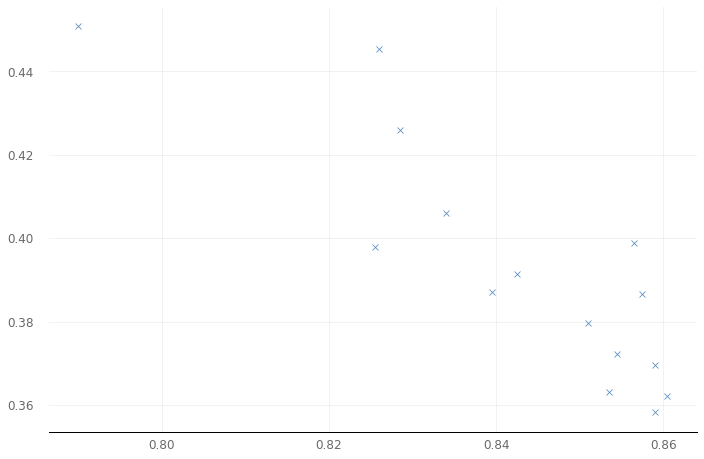

In [17]:
# Plot the regression graphs
analyze_object.plot_regs('val_accuracy', 'val_loss')

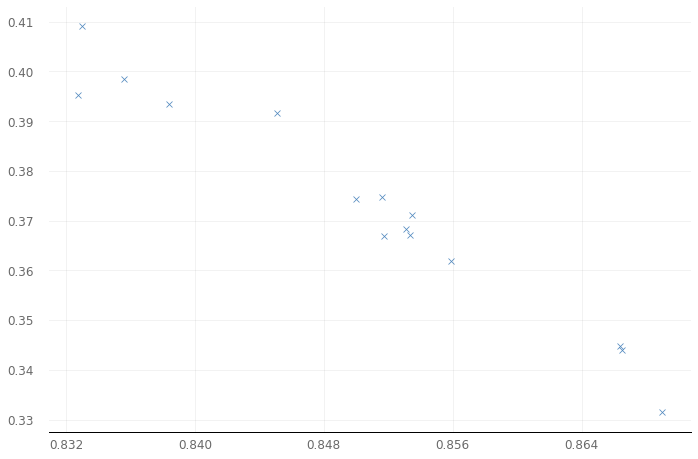

In [18]:
analyze_object.plot_regs('accuracy', 'loss')

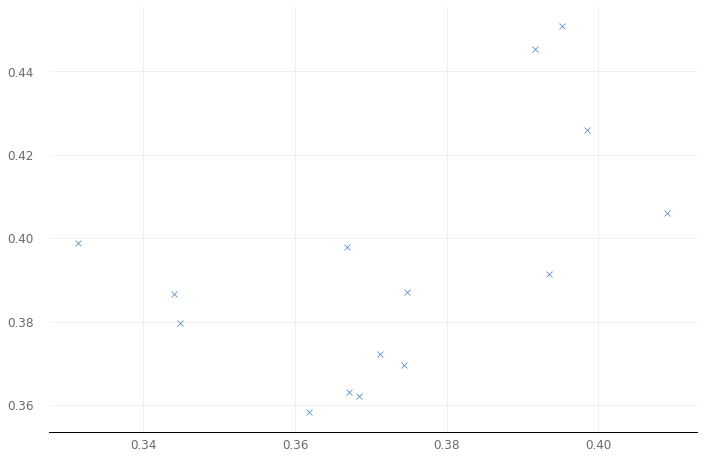

In [19]:
analyze_object.plot_regs('loss', 'val_loss')

In [35]:
# Get the best parameters
best_params = analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])
print("Best parameters:", best_params)

Best parameters: [['relu' 100 32 0.1 0.5 'binary_crossentropy' 'Adam' '03/29/23-214738' 32
  'brick' 'HeNormal' 'sigmoid' '03/29/23-214903' 51 85.17247223854065 4 0]
 ['relu' 100 32 0.01 0.0 'binary_crossentropy' 'Nadam' '03/29/23-215212'
  32 'long_funnel' 'HeNormal' 'sigmoid' '03/29/23-215339' 51
  87.55526328086853 2 1]
 ['elu' 100 32 0.1 0.5 'binary_crossentropy' 'Adamax' '03/29/23-215946'
  64 'brick' 'HeNormal' 'sigmoid' '03/29/23-220112' 51 85.6126012802124 3
  2]
 ['relu' 100 32 0.1 0.5 'binary_crossentropy' 'Adamax' '03/29/23-215123'
  32 'brick' 'HeNormal' 'sigmoid' '03/29/23-215211' 51 48.52713108062744
  2 3]
 ['relu' 100 32 0.1 0.5 'binary_crossentropy' 'Adamax' '03/29/23-220412'
  64 'long_funnel' 'GlorotNormal' 'sigmoid' '03/29/23-220536' 51
  84.68389916419983 3 4]
 ['elu' 100 32 0.1 0.5 'binary_crossentropy' 'Adamax' '03/29/23-215851'
  32 'long_funnel' 'GlorotNormal' 'sigmoid' '03/29/23-215946' 51
  54.877089977264404 2 5]
 ['relu' 100 64 0.01 0.0 'binary_crossentropy

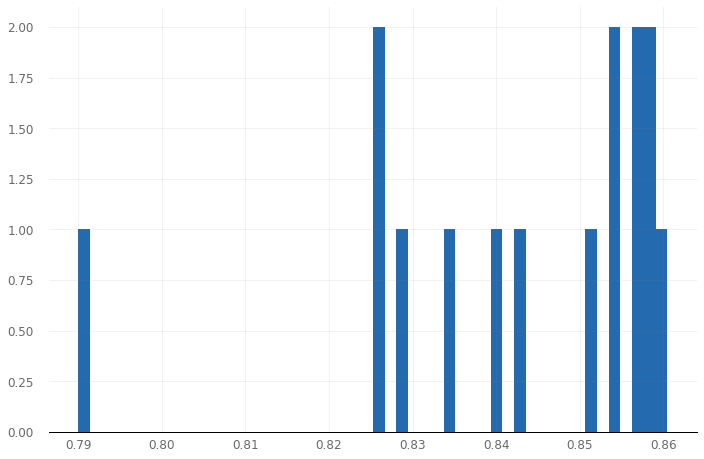

In [37]:
# Plotting different graphs
analyze_object.plot_hist('val_accuracy', bins=50)  # Histogram of the results

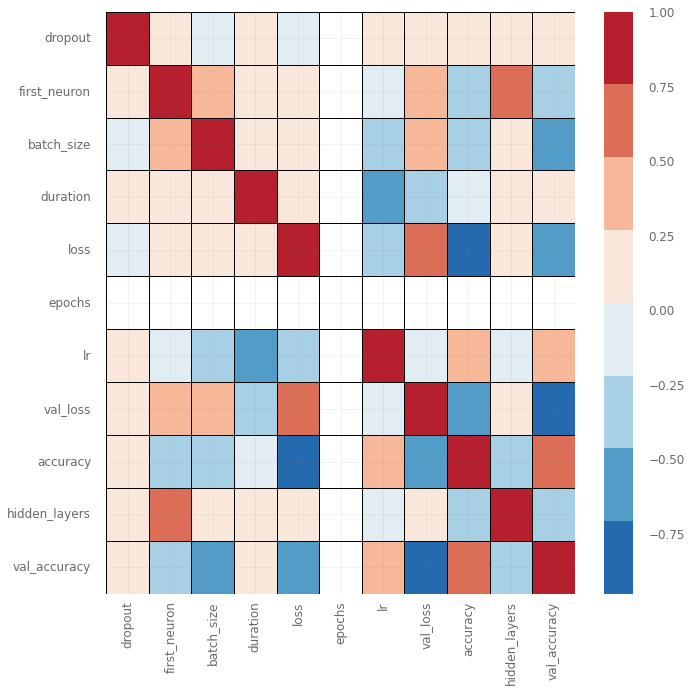

In [39]:
analyze_object.plot_corr('val_accuracy', ['round_epochs'])

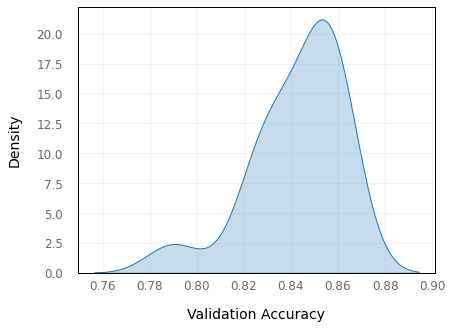

In [41]:
# Get the validation accuracy data
val_accuracy_data = analyze_object.data['val_accuracy']

# Create the KDE plot
sns.kdeplot(val_accuracy_data, shade=True)

# Set labels and show the plot
plt.xlabel('Validation Accuracy')
plt.ylabel('Density')
plt.show()

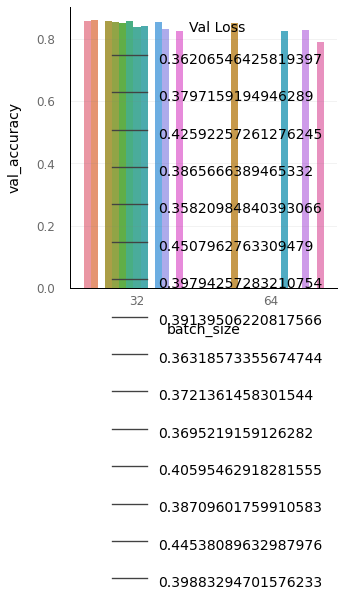

In [43]:
# Get the data from the analyze_object
results_data = analyze_object.data

# Plot the bar plot using Seaborn's catplot (updated function)
sns.catplot(x='batch_size', y='val_accuracy', hue='val_loss', data=results_data, kind='bar', legend=False)
plt.legend(title='Val Loss', loc='upper right', labels=results_data['val_loss'].unique())
plt.show()

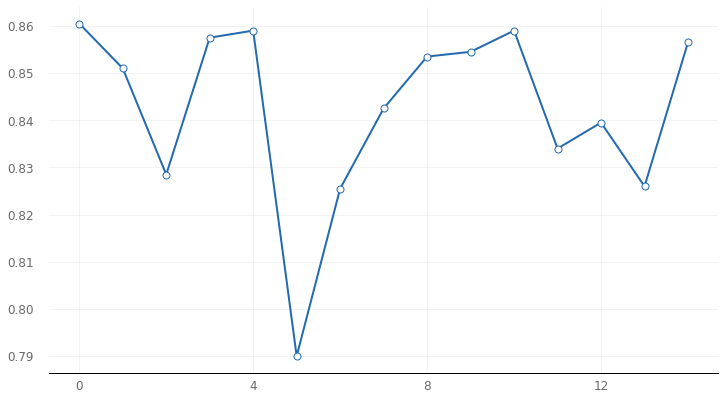

In [44]:
analyze_object.plot_line('val_accuracy')  # Line plot

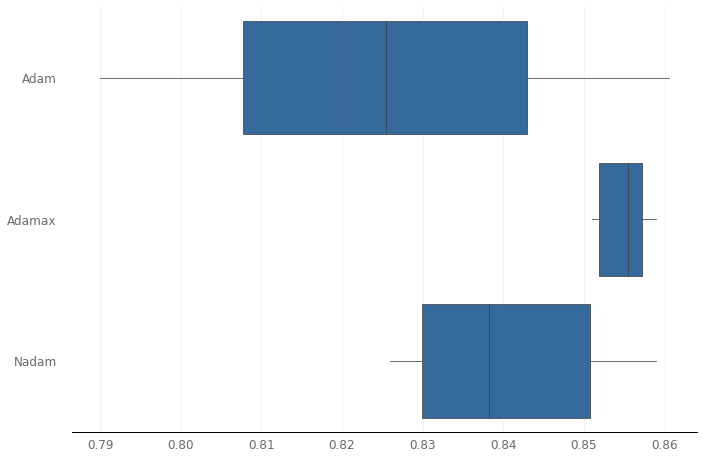

In [46]:
analyze_object.plot_box('val_accuracy', 'optimizer')  # Box plot

This code snippet evaluates the model using k-fold cross-validation for both training and testing data, deploys the best model based on validation accuracy, and restores the deployed model for further use.

In [48]:
# Evaluate the model using k-fold cross-validation
train_loss_evaluation = ta.Evaluate(scan_object).evaluate(X_train, Y_train, folds=10, metric='loss', task='continuous', asc=True)
test_loss_evaluation = ta.Evaluate(scan_object).evaluate(X_test, Y_test, folds=10, metric='val_loss', task='continuous', asc=True, shuffle=False)
train_acc_evaluation = ta.Evaluate(scan_object).evaluate(X_train, Y_train, folds=7, metric='accuracy', task='multi_class')
test_acc_evaluation = ta.Evaluate(scan_object).evaluate(X_test, Y_test, folds=7, metric='val_accuracy', task='multi_class')

7/7 [==============================] - 0s 2ms/step


In [49]:
# Deploy the best model
ta.Deploy(scan_object=scan_object, model_name='churn_deploy2', metric='val_accuracy')

# Restore the deployed model
churn = ta.Restore('churn_deploy2.zip')

Deploy package churn_deploy2 have been saved.


This code snippet makes predictions with the restored model, accesses the experiment's metadata, calculates the Mean Squared Error (MSE) for the predictions using two different reduction types, and stores the results in variables.

In [50]:
# Make predictions with the model
predictions = churn.model.predict(X_test)

# Get the meta-data for the experiment
churn_details = churn.details

# Sample of x data
churn_x = churn.x

# Sample of y data
churn_y = churn.y

# The results dataframe
churn_results = churn.results

# Calculate Mean Squared Error (MSE) using 'auto'/'sum_over_batch_size' reduction type
mse = tf.keras.losses.MeanSquaredError()
mse_result = mse(Y_test, predictions).numpy()

# Calculate Mean Squared Error (MSE) using 'none' reduction type
mse1 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mse1_result = mse1(Y_test, predictions).numpy()

63/63 [==============================] - 1s 2ms/step


This code snippet prints the first 10 predictions, the experiment's metadata, the first 10 rows of the x and y data, the results dataframe, and the Mean Squared Error (MSE) for both reduction types.

In [51]:
# Display the first 10 predictions
print("First 10 predictions:\n", predictions[:10])

First 10 predictions:
 [[0.03851617]
 [0.06197218]
 [0.73846376]
 [0.8125753 ]
 [0.19996887]
 [0.65669364]
 [0.07248233]
 [0.6032941 ]
 [0.05749111]
 [0.02566979]]


In [52]:
# Display the experiment details
print("\nExperiment details:\n", churn_details)


Experiment details:
                       0               1
0                   NaN               0
1       experiment_name           churn
2         random_method         quantum
3      reduction_method             NaN
4    reduction_interval              50
5      reduction_window              20
6   reduction_threshold             0.2
7      reduction_metric         val_acc
8         experiment_id    032923214731
9         complete_time  03/29/23/22:05
10              x_shape      (8000, 13)
11              y_shape         (8000,)


In [53]:
# Display the first 10 rows of the x data
print("\nFirst 10 rows of x data:\n", pd.DataFrame(churn_x).head(10))


First 10 rows of x data:
          0         1         2         3         4         5    6    7    8   \
0  1.380997 -0.373958 -0.695982 -1.225848  0.807737 -0.323550 -1.0 -1.0  0.0   
1 -0.243447 -1.327494 -0.350204 -1.225848 -0.911583  1.638456  1.0  1.0  0.0   
2  0.315279  0.674932 -1.733315  0.472536 -0.911583 -1.640108  1.0 -1.0  1.0   
3  1.774174  1.056346  0.687130 -1.225848  0.807737 -1.565487  1.0  1.0  1.0   
4  1.277529 -0.278604  1.032908  0.651765 -0.911583  0.030225 -1.0 -1.0  0.0   
5  1.349956 -1.518201 -1.041760  0.496000 -0.911583  1.282490  1.0 -1.0  1.0   
6  0.677416 -0.755372  1.032908  0.530372  0.807737 -0.844875  1.0  1.0  1.0   
7  0.232504  3.630893  1.724464  0.000395  0.807737 -0.704160 -1.0  1.0  0.0   
8 -0.595238 -0.660018  1.724464  1.315049 -0.911583  1.160895  1.0 -1.0  0.0   
9 -0.171020  2.295943  1.724464 -1.225848  0.807737 -1.205360  1.0 -1.0  0.0   

    9    10   11   12  
0  0.0  1.0  0.0  1.0  
1  0.0  1.0  1.0  0.0  
2  0.0  0.0  0.0  1.

In [54]:
# Display the first 10 rows of the y data
print("\nFirst 10 rows of y data:\n", pd.DataFrame(churn_y).head(10))


First 10 rows of y data:
    0
0  0
1  0
2  0
3  0
4  0
5  0
6  0
7  0
8  0
9  1


In [55]:
# Display the results dataframe
print("\nResults DataFrame:\n", churn_results)


Results DataFrame:
               start              end   duration  round_epochs      loss  \
0   03/29/23-214738  03/29/23-214903  85.172472            51  0.368367   
1   03/29/23-214903  03/29/23-214954  50.732187            51  0.344788   
2   03/29/23-214954  03/29/23-215122  87.799431            51  0.398430   
3   03/29/23-215123  03/29/23-215211  48.527131            51  0.344049   
4   03/29/23-215212  03/29/23-215339  87.555263            51  0.361796   
5   03/29/23-215340  03/29/23-215431  51.848158            51  0.395166   
6   03/29/23-215432  03/29/23-215557  84.781016            51  0.366873   
7   03/29/23-215557  03/29/23-215724  86.634471            51  0.393418   
8   03/29/23-215724  03/29/23-215850  86.579039            51  0.367138   
9   03/29/23-215851  03/29/23-215946  54.877090            51  0.371161   
10  03/29/23-215946  03/29/23-220112  85.612601            51  0.374410   
11  03/29/23-220112  03/29/23-220214  61.527363            51  0.409108   
12  

In [56]:
# Display the Mean Squared Error (MSE) for both reduction types
print("\nMean Squared Error (auto/sum_over_batch_size reduction):", mse_result)
print("Mean Squared Error (none reduction):\n", np.array(mse1_result))


Mean Squared Error (auto/sum_over_batch_size reduction): 0.2219484
Mean Squared Error (none reduction):
 [0.20269053 0.19482061 0.4413584  ... 0.178709   0.17048706 0.189918  ]


***First Model After Optimization***

---



This code snippet defines, compiles, and trains a deep neural network using the Keras Sequential API. The model is configured with He Normal weight initialization, ELU activation function, and Batch Normalization. The model is compiled using the Nadam optimizer and Binary Cross-Entropy loss function. The model's performance is evaluated on the training and test data, and the training and validation metrics are plotted to visualize the model's progress over time.

In [61]:
# Define and compile the model
model = Sequential([
    Dense(64, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.09), input_shape=(n_features,), activation='elu'),
    BatchNormalization(),
    Dense(77, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.08), activation='elu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.07), activation='elu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.06), activation='elu'),
    BatchNormalization(),
    Dense(63, kernel_initializer='HeNormal', activation='elu'),
    BatchNormalization(momentum=0.95, epsilon=0.005),
    Dense(1, activation='sigmoid', name="predictions")
])

opt = Nadam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
# Train the model
history = model.fit(X_train, Y_train, epochs=51, validation_split=0.25, batch_size=32, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/51
250/250 - 7s - loss: 3.4955 - accuracy: 0.7895 - val_loss: 0.6724 - val_accuracy: 0.7820 - 7s/epoch - 29ms/step
Epoch 2/51
250/250 - 1s - loss: 0.5929 - accuracy: 0.8035 - val_loss: 0.6126 - val_accuracy: 0.7820 - 1s/epoch - 5ms/step
Epoch 3/51
250/250 - 1s - loss: 0.5702 - accuracy: 0.8012 - val_loss: 0.5678 - val_accuracy: 0.7930 - 880ms/epoch - 4ms/step
Epoch 4/51
250/250 - 1s - loss: 0.5737 - accuracy: 0.8001 - val_loss: 0.5690 - val_accuracy: 0.7865 - 924ms/epoch - 4ms/step
Epoch 5/51
250/250 - 1s - loss: 0.5374 - accuracy: 0.8030 - val_loss: 0.7752 - val_accuracy: 0.7435 - 913ms/epoch - 4ms/step
Epoch 6/51
250/250 - 1s - loss: 0.5578 - accuracy: 0.8019 - val_loss: 0.5735 - val_accuracy: 0.7955 - 890ms/epoch - 4ms/step
Epoch 7/51
250/250 - 1s - loss: 0.5893 - accuracy: 0.7996 - val_loss: 0.6494 - val_accuracy: 0.7820 - 954ms/epoch - 4ms/step
Epoch 8/51
250/250 - 1s - loss: 0.5829 - accuracy: 0.8071 - val_loss: 0.5602 - val_accuracy: 0.7855 - 923ms/epoch - 4ms/step
Epoch

In [63]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=2)
print('Train Accuracy: %.3f' % train_acc)
test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=128, verbose=2)
print('Test Accuracy: %.3f' % test_acc)

63/63 - 0s - loss: 0.4786 - accuracy: 0.7999 - 139ms/epoch - 2ms/step
Train Accuracy: 0.800
16/16 - 0s - loss: 0.5002 - accuracy: 0.7820 - 53ms/epoch - 3ms/step
Test Accuracy: 0.782


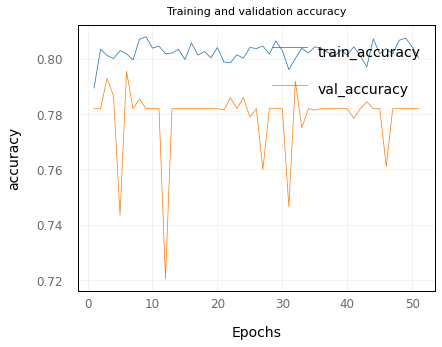

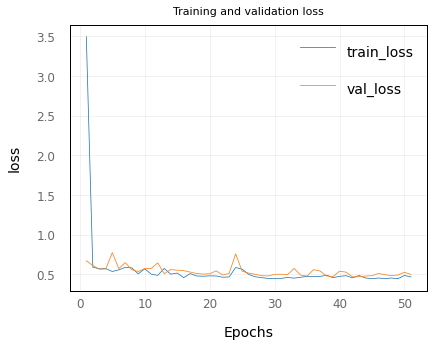

In [64]:
# Plot metrics
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

***Second Model After Optimization***

This code snippet defines, compiles, and trains a deep neural network using the Keras Sequential API. The model is configured with Glorot Normal (Xavier) weight initialization, ReLU activation function, and Batch Normalization. The model is compiled using the Adam optimizer with a learning rate of 0.1 and the Binary Cross-Entropy loss function. The model's performance is evaluated on the training data, and the training and validation metrics are plotted to visualize the model's progress over time.

In [65]:
# Define and compile the model
model = Sequential([
    Dense(32, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.1), input_shape=(n_features,), activation='relu'),
    BatchNormalization(),
    Dense(77, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.08), activation='relu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.08), activation='relu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.1), activation='relu'),
    BatchNormalization(),
    Dense(63, kernel_initializer='GlorotNormal', activation='relu'),
    BatchNormalization(momentum=0.95, epsilon=0.005),
    Dense(1, activation='sigmoid', name="predictions")
])

opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
# Train the model
history = model.fit(X_train, Y_train, epochs=51, validation_split=0.25, batch_size=32, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/51
250/250 - 6s - loss: 2.2139 - accuracy: 0.7912 - val_loss: 1.2251 - val_accuracy: 0.7825 - 6s/epoch - 25ms/step
Epoch 2/51
250/250 - 2s - loss: 1.0340 - accuracy: 0.7986 - val_loss: 0.6553 - val_accuracy: 0.7820 - 2s/epoch - 7ms/step
Epoch 3/51
250/250 - 2s - loss: 1.0275 - accuracy: 0.7971 - val_loss: 1.8553 - val_accuracy: 0.2710 - 2s/epoch - 7ms/step
Epoch 4/51
250/250 - 1s - loss: 0.8053 - accuracy: 0.7922 - val_loss: 0.9691 - val_accuracy: 0.7535 - 1s/epoch - 5ms/step
Epoch 5/51
250/250 - 1s - loss: 0.8430 - accuracy: 0.7959 - val_loss: 0.9093 - val_accuracy: 0.7820 - 724ms/epoch - 3ms/step
Epoch 6/51
250/250 - 1s - loss: 0.8246 - accuracy: 0.7962 - val_loss: 0.7734 - val_accuracy: 0.7820 - 711ms/epoch - 3ms/step
Epoch 7/51
250/250 - 1s - loss: 0.9404 - accuracy: 0.7936 - val_loss: 1.1867 - val_accuracy: 0.7820 - 719ms/epoch - 3ms/step
Epoch 8/51
250/250 - 1s - loss: 0.8127 - accuracy: 0.7958 - val_loss: 0.8941 - val_accuracy: 0.6855 - 797ms/epoch - 3ms/step
Epoch 9/51


In [67]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=1)
print('Train Accuracy: %.3f' % train_acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.8301 - accuracy: 0.7999
Train Accuracy: 0.800


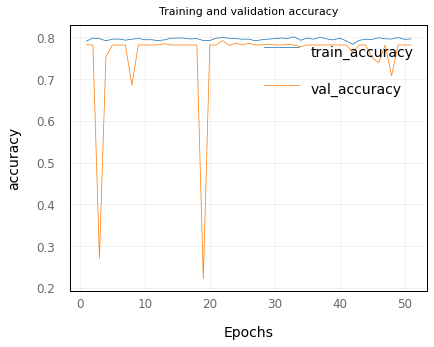

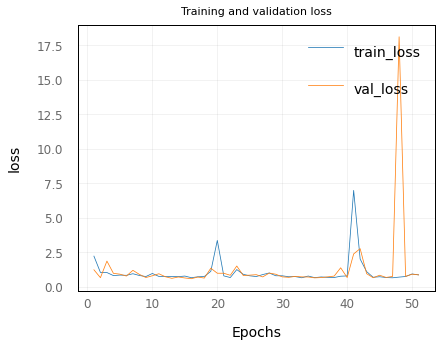

In [68]:
# Plot metrics
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

***Third Model After Optimization***

This code snippet defines, compiles, and trains a deep neural network using the Keras Sequential API. The model is configured with alternating Glorot Normal (Xavier) and He Normal weight initialization and alternating ReLU and ELU activation functions. Batch Normalization is applied with a momentum of 0.8 and epsilon of 0.001. The model is compiled using the Adamax optimizer with a learning rate of 0.001 and the Binary Cross-Entropy loss function. The model's performance is evaluated on the training data, and the training and validation metrics are plotted to visualize the model's progress over time.

In [69]:
# Define and compile the model
model = Sequential([
    Dense(100, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.01), input_shape=(n_features,), activation='relu'),
    BatchNormalization(),
    Dense(77, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.05), activation='elu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.09), activation='relu'),
    BatchNormalization(),
    Dense(70, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.11), activation='elu'),
    BatchNormalization(),
    Dense(63, kernel_initializer='GlorotNormal', activation='relu'),
    BatchNormalization(momentum=0.8, epsilon=0.001),
    Dense(1, activation='sigmoid', name="predictions")
])

opt = Adamax(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# Train the model
history = model.fit(X_train, Y_train, epochs=51, validation_split=0.25, batch_size=64, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/51
125/125 - 6s - loss: 21.0473 - accuracy: 0.7393 - val_loss: 13.8439 - val_accuracy: 0.7820 - 6s/epoch - 51ms/step
Epoch 2/51
125/125 - 1s - loss: 9.7332 - accuracy: 0.8384 - val_loss: 6.7159 - val_accuracy: 0.7820 - 715ms/epoch - 6ms/step
Epoch 3/51
125/125 - 1s - loss: 4.8191 - accuracy: 0.8506 - val_loss: 3.5730 - val_accuracy: 0.7835 - 758ms/epoch - 6ms/step
Epoch 4/51
125/125 - 1s - loss: 2.7032 - accuracy: 0.8519 - val_loss: 2.2236 - val_accuracy: 0.7865 - 763ms/epoch - 6ms/step
Epoch 5/51
125/125 - 1s - loss: 1.7540 - accuracy: 0.8554 - val_loss: 1.5416 - val_accuracy: 0.8050 - 834ms/epoch - 7ms/step
Epoch 6/51
125/125 - 1s - loss: 1.2715 - accuracy: 0.8559 - val_loss: 1.1776 - val_accuracy: 0.8120 - 1s/epoch - 9ms/step
Epoch 7/51
125/125 - 1s - loss: 1.0001 - accuracy: 0.8512 - val_loss: 0.9393 - val_accuracy: 0.8280 - 1s/epoch - 11ms/step
Epoch 8/51
125/125 - 1s - loss: 0.8153 - accuracy: 0.8546 - val_loss: 0.8035 - val_accuracy: 0.8270 - 1s/epoch - 9ms/step
Epoch 9/

In [71]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=1)
print('Train Accuracy: %.3f' % train_acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.3300 - accuracy: 0.8781
Train Accuracy: 0.878


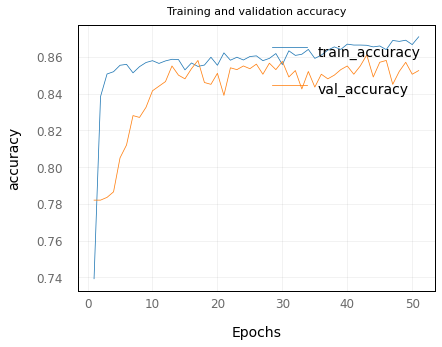

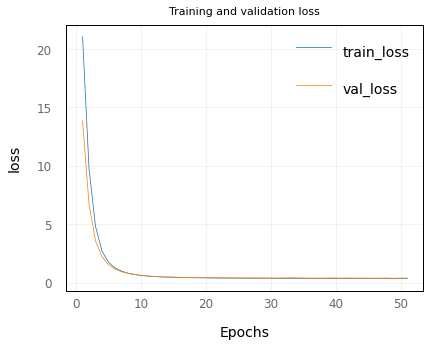

In [72]:
# Plot metrics
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')